In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rflearn.env import BlackJack, GridWorld, CliffGridWorld, WindGridWorld
from rflearn.algo import MCIteration, TabularPolicy, TabularQValue

In [2]:
def trace_avg_rewards(hist):
    trace = []
    for batch in hist:
        avg_r = 0
        for ep in batch:
            avg_r += ep.get_total_rewards()
        trace.append(avg_r / len(batch))
    return pd.Series(trace)

# Cliff Gridworld

In [36]:
cgrid = CliffGridWorld(4, 12)
qvalue = TabularQValue(cgrid.S, cgrid.A)
policy = TabularPolicy(cgrid.S, cgrid.A, epsilon=0.1)

mc_model = MCIteration(cgrid, qvalue, policy)
mc_model.fit(gamma=1, alpha=0.01)

In [37]:
mc_model.transform(1500, kbatch=30)

100%|██████████| 1500/1500 [00:50<00:00, 29.77it/s]


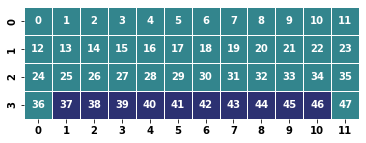

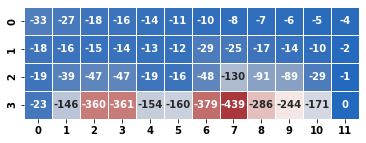

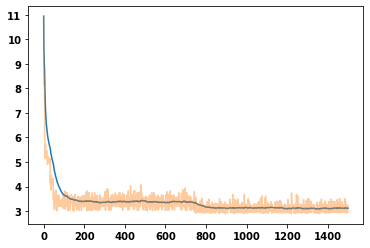

In [41]:
cgrid.plot_grid('state')
plt.show()

v_vals = qvalue.get_all_values(policy)
sns.heatmap(v_vals.reshape(cgrid.shape), square=True, cbar=False, cmap='vlag_r', linewidths=0.5, annot=True, fmt='.0f')
plt.show()

trace = np.log(-1 * trace_avg_rewards(mc_model.hist))
trace.ewm(halflife=25).mean().plot()
trace.plot(alpha=0.4)
plt.show()

# Gridworld MC

In [43]:
# _grid = [
#     [0, 1, 1, 1, 1, 1, 1],
#     [0, 0, 0, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1, 1, 0],
#     [0, 0, 0, 0, 0, 0, 0],
# ]
# grid = GridWorld(grid=_grid, terminals=[0])
grid = GridWorld(4,4)
qvalue = TabularQValue(grid.S, grid.A)
policy = TabularPolicy(grid.S, grid.A, epsilon=0.05)

mc_model = MCIteration(grid, qvalue, policy)
mc_model.fit(gamma=1)

In [44]:
mc_model.transform(iter=500, kbatch=30)

100%|██████████| 500/500 [00:01<00:00, 271.05it/s]


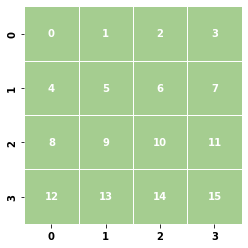

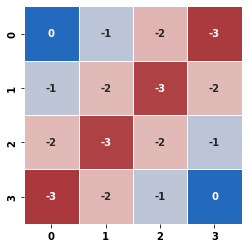

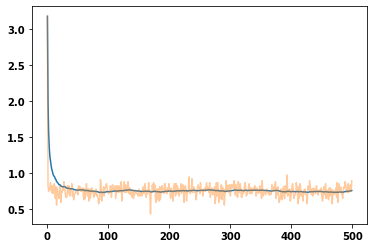

In [45]:
grid.plot_grid('state')
plt.show()

v_vals = qvalue.get_all_values(policy)
sns.heatmap(v_vals.reshape(grid.shape), square=True, cbar=False, cmap='vlag_r', linewidths=0.5, annot=True, fmt='.0f')
plt.show()

trace = np.log(-1 * trace_avg_rewards(mc_model.hist))
trace.ewm(halflife=25).mean().plot()
trace.plot(alpha=0.4)
plt.show()

# Blackjack MC

In [46]:
def fix_policy(env, eps=0.1, threshold=20):
    policy = []
    for state in env:
        if state[1] >= threshold:
            policy.append([0, 1])
        else:
            policy.append([1, 0])
    policy = TabularPolicy(
        env.S, env.A, epsilon=eps,
        policy=np.array(policy).astype('float')
    )
    return policy

In [57]:
game = BlackJack()
qvalue = TabularQValue(game.S, game.A)
policy = TabularPolicy(game.S, game.A, epsilon=0.05)

mc_model = MCIteration(game, qvalue, policy)
mc_model.fit(gamma=1)

In [58]:
mc_model.transform(15000, kbatch=20)

100%|██████████| 15000/15000 [00:45<00:00, 329.99it/s]


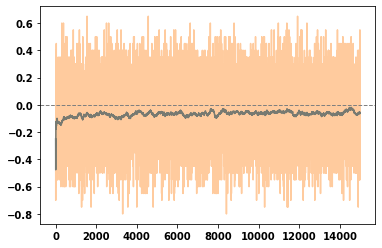

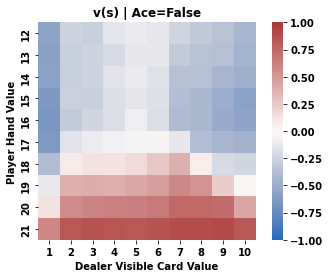

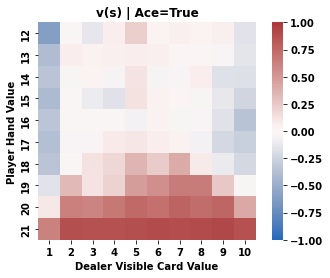

In [59]:
trace = trace_avg_rewards(mc_model.hist)
trace.ewm(halflife=100).mean().plot()
trace.plot(alpha=0.4)
plt.axhline(0, linestyle='--', color='grey',linewidth=1)
plt.show()


idx = pd.MultiIndex.from_tuples([s for s in game])
v_vals = pd.Series(qvalue.get_all_values(policy), index=idx)

# cnts = pd.Series(mc_model.sa_counts).unstack()[mc_model.env.A]
# cnts.index = idx

d = v_vals.unstack().T
for flag in [False, True]:
    ax = sns.heatmap(d[flag].T, vmin=-1, vmax=1, center=0, square=True, cmap="vlag")
    plt.title(f'v(s) | Ace={flag}')
    plt.xlabel('Dealer Visible Card Value')
    plt.ylabel('Player Hand Value')
    plt.show()